In [1]:
# Cat meow classification 
# Author: Colin Pierce
# last updated 19 May 2023
#
#
#
#    Zzzzz  |\      _,,,--,,_        +-----------------------------+
#           /,`.-'`'   ._  \-;;,_    | Why is there always a cat   |
#          |,4-  ) )_   .;.(  `'-'   | on whatever you're editing?|
#         '---''(_/._)-'(_\_)        +-----------------------------+
#
# Art by Patrick Roberts

In [2]:
# import seaborn as sns
import matplotlib.pyplot as plt
# import plotly 
import math

import pandas as pd
import numpy as np
import os
# import playsound as playsound
import ipywidgets as widgets
from ipywidgets import *
import random 
from IPython.display import Audio

from scipy.io.wavfile import read
from scipy import signal
# import plotly.graph_objs as go
# from plotly.offline import plot, iplot

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# dataset = https://zenodo.org/record/4008297; https://link.springer.com/chapter/10.1007/978-3-030-67835-7_20
# consists of 4 kHz meows when the cat was being brushed, in isolation in an unfamiliar environment, or waiting for food 

# USER: this worksheet saves to ".../[root]/dataset/..."

# Worksheet uses forward slash convention -- use backslashes if on a windows machine

/tmp/ipykernel_6812/3963911270.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, data = read("./dataset/%s"%i)


'Brushing' samples: 127, 'Food' samples: 92, 'Isolation' samples: 221

Mean, Median sample length = 1.830000 sec, 1.809562 sec
Range, Variance, Standard Deviation = 2.916000, 0.130205, 0.360840


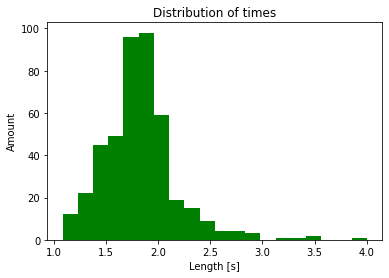

In [4]:
# begin with EDA on audio file data to motivate the appropriate transformations (warning is just for metadata)

dic = {}
names = []
totals = [0, 0, 0]
times = []

root, dirs, files = next(os.walk("./dataset/"))
for i in files:
    sit = i[0] # situation of meow (B, F, I = Brushing, Food, Isolation)
    rate, data = read("./dataset/%s"%i)
    length = len(data)/rate
    dic[i] = [rate, data, length, sit] 
    names.append(i)
    times.append(length)
    
    if sit == "B":
        totals[0] += 1
    elif sit == "F":
        totals[1] += 1
    else:
        totals[2] += 1
        
plt.hist(times, bins=20, color="green")
# plt.grid()
plt.xlabel("Length [s]")
plt.ylabel("Amount")
plt.title("Distribution of times")

stats_d = [max(times)-min(times), np.var(times), np.std(times)] # measures of dispersion

print("'Brushing' samples: %d, 'Food' samples: %d, 'Isolation' samples: %d\n"%(totals[0],totals[1],totals[2]))
print("Mean, Median sample length = %f sec, %f sec"%(round(np.average(times),2),np.median(times)))
print("Range, Variance, Standard Deviation = %f, %f, %f"%(stats_d[0],stats_d[1],stats_d[2]))

# Dataset classes are unbalanced
    

In [5]:
# Play random cat meow from database

rand_choice = names[random.randint(0,len(names))]
print("Sample meow: '%s'"%rand_choice)
Audio(filename = "./dataset/%s"%rand_choice)

Sample meow: 'F_SPI01_EU_MN_NAI01_103.wav'


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


<function __main__.show_wave(db_index)>

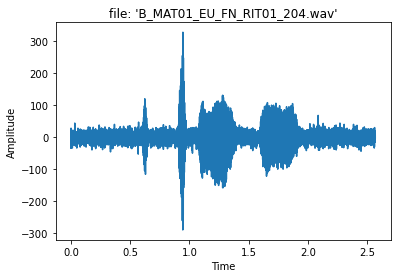

In [6]:
# Waveform plot for meows

def show_wave(db_index):
    name = names[db_index]
    # print("Meow choice: '%s'"%name )
    time = np.arange(0,dic[name][2],1/dic[name][0]) 
    data = dic[name][1]
    
    plt.plot(time,data)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("file: '%s'"%name)

interact(show_wave, db_index=widgets.IntSlider(value=0, min=0, max=len(names)-1, step=1))

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


<function __main__.show_spec(db_index)>

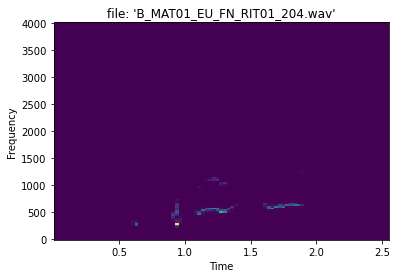

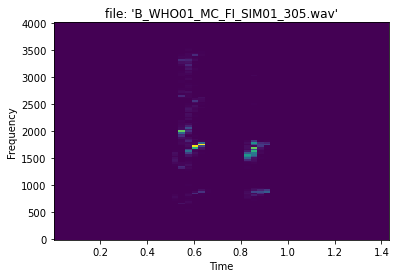

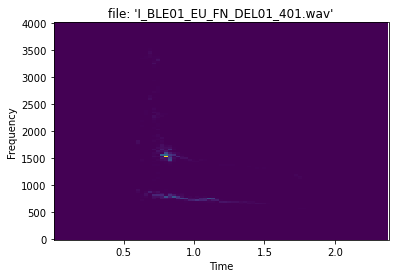

In [7]:
# Spectrogram plot for meows

def show_spec(db_index):
    name = names[db_index]
    frequencies, times, spectrogram = signal.spectrogram(dic[name][1], dic[name][0])
    
    plt.pcolormesh(times, frequencies, spectrogram)#, cmap='Greys')
    # plt.imshow(spectrogram)
    # plt.colorbar()
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title("file: '%s'"%name)

interact(show_spec, db_index=widgets.IntSlider(value=0, min=0, max=len(names)-1, step=1))

# Notice the harmonics in the meows (Eg, meow number 39, 81, 94 or 174)
# (This exists in the human voice as well and is what we will try to learn)

# Can click on db_index number to type meow index

In [8]:
# The data needs to be simplified. 
# The most audible harmonic is the loudest one. We will standardize the data by selecting the loudest power output per meow.
# We will approximate meow length by finding the range of the closest points within a close enough power range (80% of max)

In [9]:
# Find all neighboring points appropriately close to the max power output of the spectrogram

def find_neighbors(m, i, j): # grid-crawling helper function
    d_onestep = [(i+1, j), (i+1, j), (i+1,j-1), (i,j+1), (i,j-1), (i-1, j+1), (i-1, j+1), (i-1, j-1)]
    d_twostep1 = [(i+2, j), (i+2, j+1), (i+2, j+2), (i+2, j-1), (i+2, j-2), (i+1, j-2), (i+1, j+2), (i, j+2), (i, j-2)]
    d_twostep2 = [(i-1, j+2), (i-1, j-2), (i-2,j+2), (i-2,j+1), (i-2,j), (i-2,j-1), (i-2,j-2)]
    return d_onestep + d_twostep1 + d_twostep2

dic2 = {} 
index = 1
for j in names:
    sit = j[0] # meow class
    
    pts = [] # distributions
    pts_t = []
    powers = []
    ts = []
    frequencies, times, spectrogram = signal.spectrogram(dic[j][1], dic[j][0]) 
    
    #ind = np.unravel_index(np.argmax(spectrogram, axis=None), spectrogram.shape) 
    ind = np.where(spectrogram == spectrogram.max()) # find loudest frequency index
    ind = (ind[0][0], ind[1][0])
    
    lf = frequencies[ind[0]] # find time, frequency points
    lf_time = times[ind[1]]
    
    power = spectrogram[ind[0]][ind[1]] # find loudness
    
    init_power = power
    neighbors = find_neighbors(spectrogram, ind[0], ind[1]) # find loudest point neighbors
    
    
    
    # recursive crawl
    
    conv = 0 # convergence criteria
    while abs(power-init_power) < (0.8 * init_power): # power criteria
        if conv > 10: 
            break
        pts.append(ind) 
        pts_t.append((lf_time, lf))
        powers.append(power)
        ts.append(lf_time)
        
        neighbors = find_neighbors(spectrogram, ind[0], ind[1]) # find neighbors
        
        for pie in neighbors: # prevent backwards crawl
            if pie in pts:
                indd = neighbors.index(pie)
                del neighbors[indd]
        
        sub_powers = [] # find loudest of neighbors
        for foo in neighbors:
            sub_power = spectrogram[foo[0]][foo[1]]
            sub_powers.append(sub_power)
        
        power = max(sub_powers) # find loudest
        ind = neighbors[sub_powers.index(power)] # find loudest index
        lf = frequencies[ind[0]] # find time, frequency points
        lf_time = times[ind[1]]
        
        conv += 1    
        
    print("Completed: %d/%d    "%(index,len(names)), end="\r")
    index += 1
    
    rnge = max(ts)-min(ts)
    dic2[j] = [lf, rnge, pts, pts_t, powers, sit, init_power] 
    # key: freq of loudest point, range(times), pts, pts (time,freq), loudest frequencies of pts, class, max loudness

df = pd.DataFrame(dic2)
df.to_pickle("data_transform.pkl")

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


<function __main__.show_spec_mod(db_index)>

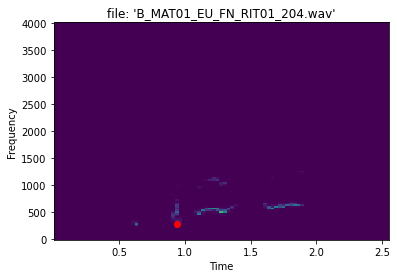

In [10]:
# Observe our extracted data superimposed on the spectrograms

df = pd.read_pickle("data_transform.pkl")

def show_spec_mod(db_index):
    name = names[db_index]
    frequencies, times, spectrogram = signal.spectrogram(dic[name][1], dic[name][0])
    
    points = df[name][2]
    x_values = []
    y_values = []
    
    for j in points:
        y_values.append(frequencies[j[0]])
        x_values.append(times[j[1]])
        
    coords = [(x_values[i], y_values[i]) for i in range(len(x_values))]
    print("Points: ", end='')
    print(coords)
    
    plt.pcolormesh(times, frequencies, spectrogram)#, cmap='Greys')
    plt.scatter(x_values, y_values, color="red")
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title("file: '%s'"%name)
    
interact(show_spec_mod, db_index=widgets.IntSlider(value=0, min=0, max=len(names)-1, step=1))

# many meows are very short and captured poorly -- these should be discarded

In [11]:
df

,B_MAT01_EU_FN_RIT01_204.wav,I_DAK01_MC_FN_SIM01_110.wav,F_LEO01_EU_MI_RIT01_104.wav,B_JJX01_MC_FN_SIM01_301.wav,I_DAK01_MC_FN_SIM01_108.wav,F_CAN01_EU_FN_GIA01_202.wav,F_SPI01_EU_MN_NAI01_202.wav,I_WHO01_MC_FI_SIM01_101.wav,B_REG01_EU_FN_GIO01_201.wav,F_MAG01_EU_FN_FED01_104.wav,...,F_DAK01_MC_FN_SIM01_301.wav,I_MEG01_MC_FI_SIM01_104.wav,F_BAC01_MC_MN_SIM01_303.wav,B_DAK01_MC_FN_SIM01_303.wav,I_BLE01_EU_FN_DEL01_219.wav,F_DAK01_MC_FN_SIM01_303.wav,F_WHO01_MC_FI_SIM01_102.wav,B_CAN01_EU_FN_GIA01_305.wav,I_CAN01_EU_FN_GIA01_303.wav,I_CAN01_EU_FN_GIA01_102.wav
0,343.75,1250.0,1093.75,1656.25,1375.0,781.25,2250.0,937.5,2812.5,2218.75,...,2093.75,1593.75,1375.0,1625.0,1531.25,2406.25,1718.75,500.0,2375.0,1937.5
1,0.0,0.056,0.168,0.028,0.112,0.14,0.112,0.14,0.028,0.14,...,0.028,0.112,0.056,0.056,0.028,0.028,0.112,0.28,0.084,0.056
2,"[(9, 33)]","[(40, 31), (40, 30), (41, 32), (41, 31), (41, ...","[(34, 22), (33, 20), (32, 21), (34, 21), (35, ...","[(50, 28), (49, 29), (51, 28), (51, 29)]","[(44, 29), (44, 28), (43, 29), (44, 29), (43, ...","[(26, 27), (26, 29), (24, 30), (25, 28), (26, ...","[(72, 31), (72, 33), (72, 32), (72, 31), (72, ...","[(33, 21), (32, 20), (32, 22), (31, 23), (31, ...","[(88, 43), (89, 42), (88, 43), (90, 42)]","[(79, 27), (80, 26), (79, 27), (78, 28), (76, ...",...,"[(65, 32), (66, 32), (64, 32), (65, 32), (66, ...","[(50, 24), (50, 23), (51, 25), (51, 24), (51, ...","[(43, 26), (43, 27), (43, 25)]","[(52, 38), (52, 37), (51, 39), (51, 38), (52, ...","[(47, 31), (48, 31), (50, 30), (51, 30)]","[(77, 20), (75, 19)]","[(56, 36), (56, 35), (56, 37), (56, 38), (56, ...","[(18, 32), (18, 33), (18, 34), (18, 36), (17, ...","[(77, 33), (76, 34), (75, 35), (75, 34), (76, ...","[(62, 25), (61, 26), (61, 25), (62, 25), (61, ..."
3,"[(0.94, 281.25)]","[(0.884, 1250.0), (0.856, 1250.0), (0.912, 128...","[(0.632, 1062.5), (0.576, 1031.25), (0.604, 10...","[(0.8, 1562.5), (0.828, 1531.25), (0.8, 1593.7...","[(0.828, 1375.0), (0.8, 1375.0), (0.828, 1343....","[(0.772, 812.5), (0.828, 812.5), (0.856, 750.0...","[(0.884, 2250.0), (0.94, 2250.0), (0.912, 2250...","[(0.604, 1031.25), (0.576, 1000.0), (0.632, 10...","[(1.22, 2750.0), (1.192, 2781.25), (1.22, 2750...","[(0.772, 2468.75), (0.744, 2500.0), (0.772, 24...",...,"[(0.912, 2031.25), (0.912, 2062.5), (0.912, 20...","[(0.688, 1562.5), (0.66, 1562.5), (0.716, 1593...","[(0.744, 1343.75), (0.772, 1343.75), (0.716, 1...","[(1.08, 1625.0), (1.052, 1625.0), (1.108, 1593...","[(0.884, 1468.75), (0.884, 1500.0), (0.856, 15...","[(0.576, 2406.25), (0.548, 2343.75)]","[(1.024, 1750.0), (0.996, 1750.0), (1.052, 175...","[(0.912, 562.5), (0.94, 562.5), (0.968, 562.5)...","[(0.94, 2406.25), (0.968, 2375.0), (0.996, 234...","[(0.716, 1937.5), (0.744, 1906.25), (0.716, 19..."
4,[181.77066],"[609457.2, 196260.67, 321798.78, 157704.48, 14...","[1088.1702, 598.9025, 294.99423, 508.19696, 92...","[3792.4055, 3106.7134, 1913.8121, 1881.0771]","[446969.12, 272157.7, 97254.5, 446969.12, 1298...","[1142.4883, 933.98065, 686.80707, 464.5754, 73...","[58178.72, 54254.54, 51668.3, 58178.72, 42801....","[871798.3, 565583.44, 369173.3, 214016.88, 195...","[5647.2866, 1752.8956, 5647.2866, 1678.4902]","[48618.305, 45304.84, 48618.305, 36811.96, 209...",...,"[130872.06, 125134.85, 37557.926, 130872.06, 1...","[269654.66, 144212.16, 145386.62, 125560.586, ...","[235463.4, 114235.79, 74629.36]","[285849.94, 177549.92, 165795.77, 64169.395, 2...","[29805.486, 21312.531, 8968.178, 9195.192]","[8398.359, 3291.7427]","[1178624.1, 1177768.0, 1148614.9, 828563.2, 36...","[1590.7614, 1529.5028, 1355.6929, 900.672, 896...","[19975.145, 18321.354, 12340.023, 9245.876, 18...","[66902.31, 19665.348, 66034.54, 66902.31, 1966..."
5,B,I,F,B,I,F,F,I,B,F,...,F,I,F,B,I,F,F,B,I,I
6,181.77066,609457.1875,1088.170166,3792.405518,446969.125,1142.488281,58178.71875,871798.3125,5647.286621,48618.304688,...,130872.0625,269654.65625,235463.40625,285849.9375,29805.486328,8398.359375,1178624.125,1590.761353,19975.144531,66902.3

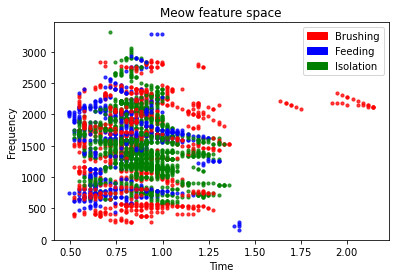

In [12]:
# Plot meow features space

import matplotlib.patches as mpatches

labels = []
for r in df:
    x_values = []
    y_values = []
    
    frequencies, times, spectrogram = signal.spectrogram(dic[r][1], dic[r][0])
    
    pts = df[r][2]
    for i in pts:
        y_values.append(frequencies[i[0]])
        x_values.append(times[i[1]])
        
    sit = df[r][5]
    labels.append(sit)
    colors = {"B":"red", "F":"blue", "I":"green"} 

    #if len(set(xs))==len(xs):
    plt.scatter(x_values, y_values, s=10, c=colors[sit], label=str(sit), alpha=0.75)
        
red = mpatches.Patch(color='red', label='Brushing')
blue = mpatches.Patch(color='blue', label='Feeding')
green = mpatches.Patch(color='green', label='Isolation')

plt.title("Meow feature space")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend(handles=[red, blue, green], loc = 'upper right')

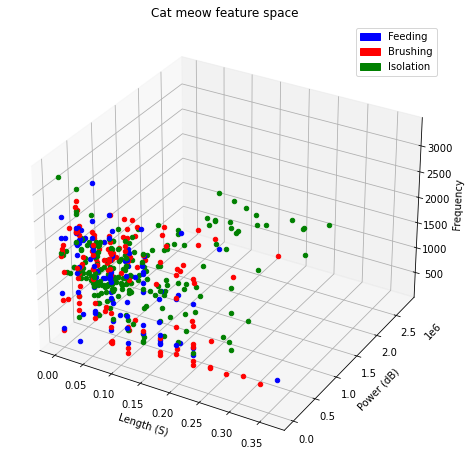

In [13]:
# Plot features in 3-space

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')  

colors = {"B":"red", "F":"blue", "I":"green"} 

labels = []
for r in df:
    sit = df[r][5]
    labels.append(sit)
    
    ax.scatter(df[r][1], df[r][6], df[r][0],  c=colors[sit])#, s = 10, c=colors[sit], label = str(sit), alpha = 0.75)
    # length by power by freq
    
colors = {"B":"red", "F":"blue", "I":"green"} 
    
red = mpatches.Patch(color='red', label='Brushing')
blue = mpatches.Patch(color='blue', label='Feeding')
green = mpatches.Patch(color='green', label='Isolation')

plt.title("Cat meow feature space")

ax.set_xlabel('Length (S)')
ax.set_ylabel('Power (dB)')
ax.set_zlabel('Frequency')

plt.legend(handles = [blue, red, green], loc='upper right')
plt.show()

# Outliers could suggest that cats meow the loudest when isolated.

In [14]:
# Transpose dataframe for modeling

freqs = []
pwrs = []
lens = []
clss = []

key = {"B":0, "F":1, "I":2}
for j in df:
    freqs.append(df[j][0])
    lens.append(df[j][1])
    clss.append(key[df[j][5]])
    pwrs.append(df[j][6])

df2 = {"freq":freqs, "power":pwrs, "lengths":lens, "class":clss}
df2 = pd.DataFrame(df2)
# df2.shape
df2

,freq,power,lengths,class
0,343.75,1.817707e+02,0.000,0
1,1250.00,6.094572e+05,0.056,2
2,1093.75,1.088170e+03,0.168,1
3,1656.25,3.792406e+03,0.028,0
4,1375.00,4.469691e+05,0.112,2
...,...,...,...,...
435,2406.25,8.398359e+03,0.028,1
436,1718.75,1.178624e+06,0.112,1
437,500.00,1.590761e+03,0.280,0
438,2375.00,1.997514e+04,0.084,2


In [15]:
# Hide class column for training

X_data = df2.drop(['class'], axis=1)
data = pd.DataFrame(X_data, columns=['freq', 'power', 'lengths'])
y_data = df2['class']
data

,freq,power,lengths
0,343.75,1.817707e+02,0.000
1,1250.00,6.094572e+05,0.056
2,1093.75,1.088170e+03,0.168
3,1656.25,3.792406e+03,0.028
4,1375.00,4.469691e+05,0.112
...,...,...,...
435,2406.25,8.398359e+03,0.028
436,1718.75,1.178624e+06,0.112
437,500.00,1.590761e+03,0.280
438,2375.00,1.997514e+04,0.084


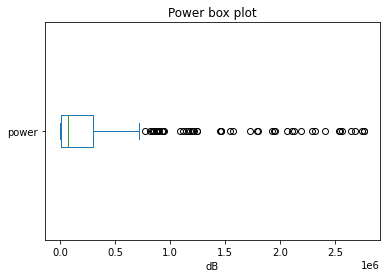

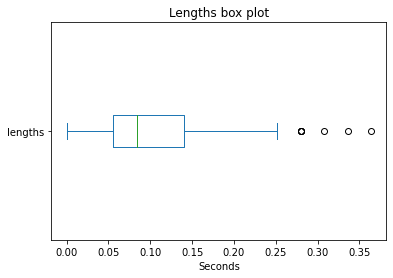

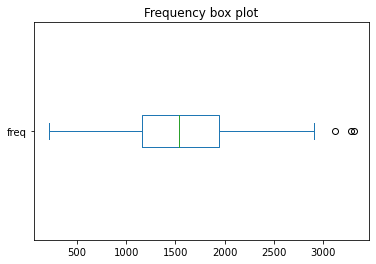

In [16]:
# Feature box plots

data['power'].plot(kind='box', vert=False) # many high-power outliers
plt.title("Power box plot")
plt.xlabel('dB')
plt.show()

data['lengths'].plot(kind='box', vert=False)
plt.title("Lengths box plot")
plt.xlabel('Seconds')
plt.show()

data['freq'].plot(kind='box', vert=False)
plt.title("Frequency box plot")
plt.show()

In [17]:
# Dummy classifier

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2, random_state=1)

dummy = DummyClassifier()

dummy.fit(X_train,y_train)

y_pred = dummy.predict(X_test)

# Test model

res = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(res)
print("\n\n")

res2 = classification_report(y_test, y_pred)
print('Classification report:')
print(res2)

res3 = accuracy_score(y_test, y_pred)
print("Accuracy:", res3)

# Cross validate

print("\n\n Cross Validation:\n")

scores = cross_val_score(dummy, data, y_data, cv=10)
print("Scores:", scores)
print("Mean:", np.mean(scores))
print('Std:', np.std(scores))

Confusion matrix:
[[ 9  8 11]
 [ 7  3 12]
 [13  6 19]]



Classification report:
              precision    recall  f1-score   support

           0       0.31      0.32      0.32        28
           1       0.18      0.14      0.15        22
           2       0.45      0.50      0.48        38

    accuracy                           0.35        88
   macro avg       0.31      0.32      0.31        88
weighted avg       0.34      0.35      0.34        88

Accuracy: 0.3522727272727273


 Cross Validation:

Scores: [0.34090909 0.40909091 0.31818182 0.34090909 0.36363636 0.34090909
 0.38636364 0.40909091 0.22727273 0.45454545]
Mean: 0.35909090909090907
Std: 0.0590909090909091


/usr/lib/python3/dist-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "
/usr/lib/python3/dist-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [18]:
# KNN model

from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2, random_state=1)

knn = KNeighborsClassifier()

knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

# Test model

res = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(res)
print("\n\n")

res2 = classification_report(y_test, y_pred)
print('Classification report:')
print(res2)

res3 = accuracy_score(y_test, y_pred)
print("Accuracy:", res3)

# Cross validate

print("\n\n Cross Validation:\n")

scores = cross_val_score(knn, data, y_data, cv=10)
print("Scores:", scores)
print("Mean:", np.mean(scores))
print('Std:', np.std(scores))

# predictions = cross_val_predict(knn, data, y_data, cv=10)

Confusion matrix:
[[ 9  3 16]
 [13  3  6]
 [ 5  3 30]]



Classification report:
              precision    recall  f1-score   support

           0       0.33      0.32      0.33        28
           1       0.33      0.14      0.19        22
           2       0.58      0.79      0.67        38

    accuracy                           0.48        88
   macro avg       0.41      0.42      0.40        88
weighted avg       0.44      0.48      0.44        88

Accuracy: 0.4772727272727273


 Cross Validation:

Scores: [0.43181818 0.47727273 0.54545455 0.43181818 0.59090909 0.54545455
 0.45454545 0.70454545 0.47727273 0.5       ]
Mean: 0.5159090909090909
Std: 0.08006324979003882


In [19]:
# Decision tree model

from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2, random_state=1)

tree = DecisionTreeClassifier(max_depth=2)

tree.fit(X_train, y_train)

ypred = tree.predict(X_test)

# Test model

res = confusion_matrix(y_test, ypred)
print('Confusion matrix:')
print(res)
print("\n")

res2 = classification_report(y_test, ypred)
print('Classification report:')
print(res2)

res3 = accuracy_score(y_test, ypred)
print("Accuracy:", res3)

# Cross validate

print("\n\n Cross Validation:\n")

scores = cross_val_score(tree, data, y_data, cv=10)
print("Scores:", scores)
print("Mean:", np.mean(scores))
print('Std:', np.std(scores))

# Tree doesn't learn middle feature

Confusion matrix:
[[18  0 10]
 [19  0  3]
 [11  0 27]]


Classification report:
              precision    recall  f1-score   support

           0       0.38      0.64      0.47        28
           1       0.00      0.00      0.00        22
           2       0.68      0.71      0.69        38

    accuracy                           0.51        88
   macro avg       0.35      0.45      0.39        88
weighted avg       0.41      0.51      0.45        88

Accuracy: 0.5113636363636364


 Cross Validation:

Scores: [0.36363636 0.56818182 0.63636364 0.52272727 0.52272727 0.5
 0.52272727 0.68181818 0.5        0.56818182]
Mean: 0.5386363636363637
Std: 0.08134331894624218


/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Models are unlikely to have learned any meaningful features

In [21]:
# Retry by removing poorly captured meows

df2 = df2[df2['lengths'] > 0.1] # meow length > 0.1 seconds
# df2

,freq,power,lengths,class
2,1093.75,1.088170e+03,0.168,1
4,1375.00,4.469691e+05,0.112,2
5,781.25,1.142488e+03,0.140,1
6,2250.00,5.817872e+04,0.112,1
7,937.50,8.717983e+05,0.140,2
...,...,...,...,...
424,812.50,6.157323e+03,0.224,0
425,531.25,1.060400e+03,0.224,0
431,1593.75,2.696547e+05,0.112,2
436,1718.75,1.178624e+06,0.112,1


In [22]:
# Hide class column for training

X_data = df2.drop(['class'], axis=1)
data = pd.DataFrame(X_data, columns=['freq', 'power', 'lengths'])
y_data = df2['class']

In [23]:
# KNN model

from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2, random_state=1)

knn = KNeighborsClassifier()

knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

# Test model

res = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(res)
print("\n\n")

res2 = classification_report(y_test, y_pred)
print('Classification report:')
print(res2)

res3 = accuracy_score(y_test, y_pred)
print("Accuracy:", res3)

# Cross validate

print("\n\n Cross Validation:\n")

scores = cross_val_score(knn, data, y_data, cv=10)
print("Scores:", scores)
print("Mean:", np.mean(scores))
print('Std:', np.std(scores))

Confusion matrix:
[[2 3 7]
 [5 0 3]
 [5 0 8]]



Classification report:
              precision    recall  f1-score   support

           0       0.17      0.17      0.17        12
           1       0.00      0.00      0.00         8
           2       0.44      0.62      0.52        13

    accuracy                           0.30        33
   macro avg       0.20      0.26      0.23        33
weighted avg       0.24      0.30      0.26        33

Accuracy: 0.30303030303030304


 Cross Validation:

Scores: [0.41176471 0.58823529 0.47058824 0.23529412 0.4375     0.4375
 0.5        0.5625     0.5        0.6875    ]
Mean: 0.48308823529411765
Std: 0.11424539923198107


In [24]:
# Decision tree model

from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.2, random_state=1)

tree = DecisionTreeClassifier(max_depth=2)

tree.fit(X_train, y_train)

ypred = tree.predict(X_test)

# Test model

res = confusion_matrix(y_test, ypred)
print('Confusion matrix:')
print(res)
print("\n")

res2 = classification_report(y_test, ypred)
print('Classification report:')
print(res2)

res3 = accuracy_score(y_test, ypred)
print("Accuracy:", res3)

# Cross validate

print("\n\n Cross Validation:\n")

scores = cross_val_score(tree, data, y_data, cv=10)
print("Scores:", scores)
print("Mean:", np.mean(scores))
print('Std:', np.std(scores))

Confusion matrix:
[[1 5 6]
 [0 7 1]
 [2 6 5]]


Classification report:
              precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.39      0.88      0.54         8
           2       0.42      0.38      0.40        13

    accuracy                           0.39        33
   macro avg       0.38      0.45      0.36        33
weighted avg       0.38      0.39      0.34        33

Accuracy: 0.3939393939393939


 Cross Validation:

Scores: [0.52941176 0.64705882 0.41176471 0.41176471 0.5625     0.375
 0.5        0.5625     0.5625     0.6875    ]
Mean: 0.525
Std: 0.09711451165352386


In [25]:
# Accuracy does not improve